# **Libraries**

In [1]:
# import library
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#**Importation des données**  

In [ ]:
# Ajustez le chemin selon l'emplacement réel de votre fichier
data = pd.read_csv("guillaume.txt", sep=";")

# **Traitement de données**

In [3]:
def nettoyer_colonnes_par_indices(data, indices_colonnes):
    """
    Nettoie plusieurs colonnes spécifiées par leurs indices en supprimant les espaces,
    convertissant les valeurs en numérique, supprimant les valeurs non valides,
    et en les convertissant en entiers.

    Args:
        data (pd.DataFrame): Le DataFrame à traiter.
        indices_colonnes (list): Liste des indices des colonnes à nettoyer.

    Returns:
        pd.DataFrame: Le DataFrame avec les colonnes nettoyées.
    """
    # Parcourir les indices des colonnes
    for indice in indices_colonnes:
        # Obtenir le nom de la colonne depuis l'indice
        colonne = data.columns[indice]

        # Supprimer les espaces
        data[colonne] = data[colonne].astype(str).str.strip()
        # Convertir en numérique (remplace les erreurs par NaN)
        data[colonne] = pd.to_numeric(data[colonne], errors='coerce')
        # Supprimer les lignes avec des NaN dans la colonne
        data = data.dropna(subset=[colonne])
        # Convertir les valeurs en entiers
        data[colonne] = data[colonne].astype(int)

    return data

In [ ]:
# Liste des indices des colonnes à nettoyer
indices_colonnes = [1,2,5,6,7,8,9,15,16,22]

# Nettoyage des colonnes
data = nettoyer_colonnes_par_indices(data, indices_colonnes)

In [ ]:
# verifier les types de mes données
data.dtypes

In [ ]:
col_flot = ["Montant", "TauxImpNb_RB","TauxImpNB_CPM", "CA3TRetMtt", "CA3TR","ScoringFP1", 	"ScoringFP2", 	"ScoringFP3"]
col_str = ["ZIBZIN","IDAvisAutorisationCheque"]
co_date = ["DateTransaction"]
col_heure = ["Heure"]
# recuperer toutes les colonnnes qui ne foont pas parti de col_flot, col_str, col_heure, col_date dans col_int
col_int = [col for col in data.columns if col not in col_flot and col not in col_str and col not in col_heure and col not in co_date]
# afficher le nombre de chacune des liste
print("col_flot :", len(col_flot))
print("col_str :", len(col_str))
print("col_int :", len(col_int))
print("co_date :", len(co_date))
print("col_heure :", len(col_heure))

In [7]:
for col in col_flot:
    # Remplacer les virgules par des points dans les colonnes de type string
    data[col] = data[col].astype(str).str.replace(',', '.', regex=False)

    # Convertir les colonnes au type float
    data[col] = data[col].astype(float)

In [8]:
# Convertir en int
for col in col_int:
    # Vérifier si la colonne n'est pas déjà de type int
    if data[col].dtype != 'int64':
        # Remplacer les virgules par des points, si nécessaire
        data[col] = data[col].astype(str).str.replace(',', '.')
        # Convertir en type float puis en int (pour éviter les problèmes avec les décimales)
        data[col] = data[col].astype(float).astype(int)

In [9]:
# convertir la col_date en type date
data['DateTransaction'] = pd.to_datetime(data['DateTransaction'])


In [10]:
# Conversion des secondes depuis minuit en format timedelta
data['Heure'] = pd.to_timedelta(data['Heure'], unit='s')

# Convertir en format HH:MM:SS en chaîne (ou datetime.time si nécessaire)
data['Heure'] = data['Heure'].apply(lambda x: (pd.Timestamp("00:00:00") + x).time())

# **Analyse Exploratoire des Données**

In [ ]:
# afficher la liste des colonnes
data.columns

In [ ]:
# Histogramme des montants de transactions
sns.histplot(data["Montant"], bins=50, kde=True)
plt.title("Distribution des montants des transactions")
plt.xlabel("Montant (€)")
plt.ylabel("Fréquence")
plt.show()

In [ ]:

# Boxplot des montants des transactions
plt.figure(figsize=(12, 6))
sns.boxplot(x=data["Montant"])
plt.title("Boxplot des montants des transactions")
plt.xlabel("Montant (€)")
plt.show()

In [ ]:
# Ajouter une colonne pour le mois et le jour
data['Mois'] = data['DateTransaction'].dt.month
data['Jour'] = data['DateTransaction'].dt.day

# Grouper les données par mois et jour et calculer la somme des montants
data_grouped = data.groupby(['Mois', 'Jour'])['Montant'].sum().reset_index()

# Créer le graphique
plt.figure(figsize=(14, 8))
sns.lineplot(data=data_grouped, x='Jour', y='Montant', hue='Mois', palette='tab10')
plt.title('Montant des transactions par mois selon les jours')
plt.xlabel('Jour')
plt.ylabel('Montant (€)')
plt.legend(title='Mois', loc='upper right')
plt.show()

In [ ]:
# liste des elements en flagImpaye
data['FlagImpaye'].value_counts()

# Graphique des transactions circulaires flagImpaye
plt.figure(figsize=(6, 6))
data['FlagImpaye'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Répartition des transactions impayées')
plt.show()

In [ ]:
# Boxplot des montants des transactions selon le flagImpaye avec des couleurs
plt.figure(figsize=(12, 6))
sns.boxplot(x='FlagImpaye', y='Montant', hue='FlagImpaye', data=data, palette='Set2', legend=False)
plt.title('Montant des transactions selon le flagImpaye')
plt.xlabel('FlagImpaye')
plt.ylabel('Montant (€)')
plt.show()

In [ ]:
# Définir le style de seaborn
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Créer la figure avec un ratio d'aspect spécifique
plt.figure(figsize=(12, 6))

# Créer le boxplot avec les paramètres corrigés
ax = sns.boxplot(x='FlagImpaye', 
                 y='Montant', 
                 hue='FlagImpaye',  # Ajout du paramètre hue
                 data=data,
                 palette=['#2ecc71', '#e74c3c'],
                 width=0.5,
                 linewidth=2,
                 fliersize=5,
                 showfliers=True,
                 legend=False)  # Désactiver la légende car redondante

# Personnaliser les étiquettes
plt.title('Distribution des Montants de Transaction par Statut de Paiement', 
          pad=20, 
          fontsize=14, 
          fontweight='bold')
plt.xlabel('Statut du Paiement', fontsize=12)
plt.ylabel('Montant (€)', fontsize=12)

# Personnaliser les étiquettes de l'axe x
ax.set_xticklabels(['Payé', 'Impayé'], fontsize=10)

# Ajouter une grille horizontale plus subtile
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Personnaliser les bordures
sns.despine(left=False, bottom=False)

# Ajuster les marges
plt.tight_layout()

# Ajouter des statistiques descriptives sous forme de texte
stats = data.groupby('FlagImpaye')['Montant'].describe()
y_max = data['Montant'].max()
for i, flag in enumerate([0, 1]):
    plt.text(i, y_max*1.02,
             f'Moyenne: {stats.loc[flag, "mean"]:.2f}€\n'
             f'Médiane: {stats.loc[flag, "50%"]:.2f}€',
             horizontalalignment='center',
             verticalalignment='bottom',
             fontsize=9)

plt.show()

In [ ]:
#  type des colonnes
data.dtypes

In [42]:
# selectionner les colonnes de type object
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
import numpy as np
# Calculer la matrice de corrélation
corr_matrix = data[numeric_columns].corr()

# Créer la figure avec une taille adaptée
plt.figure(figsize=(20, 16))

# Créer un masque pour le triangle supérieur
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Créer la heatmap avec des paramètres améliorés
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,  # Afficher les valeurs
            fmt='.2f',   # Format à 2 décimales
            cmap='RdYlBu_r',  # Palette de couleurs (rouge pour négatif, bleu pour positif)
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .5},
            vmin=-1, vmax=1,
            annot_kws={"size": 8})

# Rotation des labels pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Titre du graphique
plt.title('Matrice de Corrélation des Variables', 
          pad=20,
          fontsize=16,
          fontweight='bold')

# Ajuster la mise en page
plt.tight_layout()

# Afficher le graphique
plt.show()

In [ ]:
# Repartiion des  transactions par CodeDecision 
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='CodeDecision', palette='viridis')
plt.title('Répartition des transactions par CodeDecision')
plt.xlabel('CodeDecision')

In [ ]:
# Afficher la liste des transactions refusées par mois FlagImpaye = 1
data_refuse = data[data['FlagImpaye'] == 1]
data_refuse['Mois'].value_counts()

# Créer le graphique
plt.figure(figsize=(12, 6))
sns.countplot(data=data_refuse, x='Mois', palette='viridis')
plt.title('Transactions refusées par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de transactions refusées')
plt.show()

C:\Windows\Temp\ipykernel_9692\1116797991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_refuse['JourSemaine'] = data_refuse['DateTransaction'].dt.day_name()


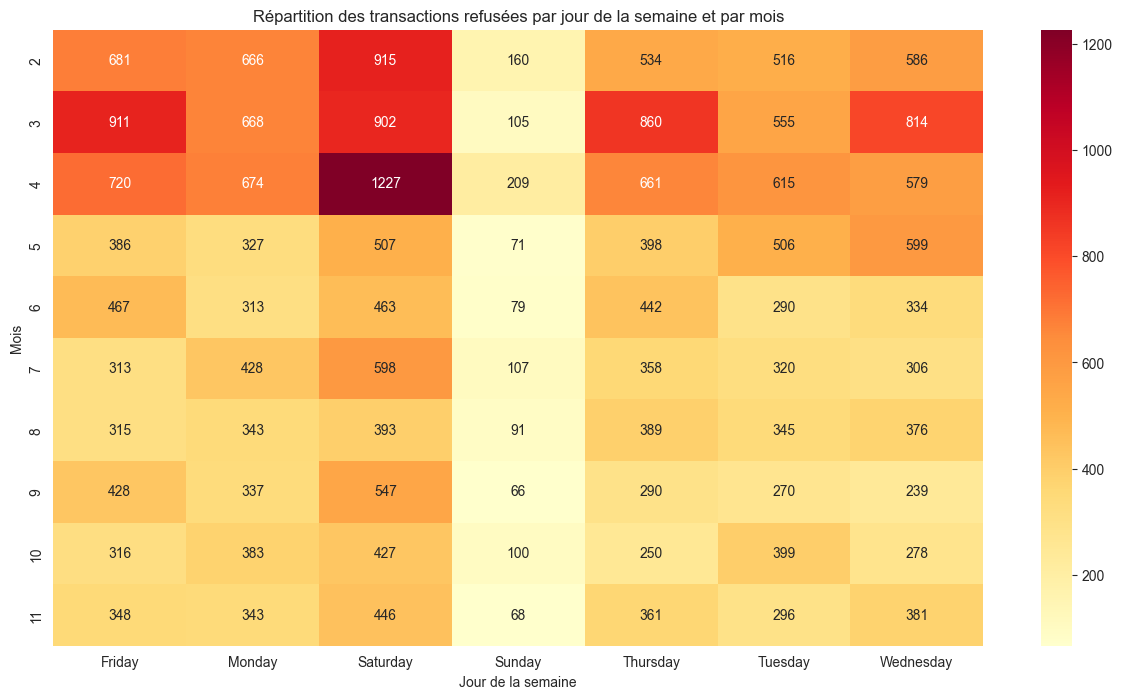

In [50]:
# Ajoutons le jour de la semaine
data_refuse['JourSemaine'] = data_refuse['DateTransaction'].dt.day_name()

# Analyse croisée : jour de la semaine par mois
plt.figure(figsize=(15, 8))
cross_tab = pd.crosstab(data_refuse['Mois'], data_refuse['JourSemaine'])
sns.heatmap(cross_tab, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Répartition des transactions refusées par jour de la semaine et par mois')
plt.xlabel('Jour de la semaine')
plt.ylabel('Mois')
plt.show()
